# The Federalist Papers

https://drive.google.com/file/d/12R9d52iTQZnKCdOmN-8DCy7oVLFxiX4G/view?usp=sharing


In [1]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='12R9d52iTQZnKCdOmN-8DCy7oVLFxiX4G',dest_path='./content', unzip=True)

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Constants for Hamilton/Madison
AH = 0
JM = 1
UNKNOWN = -1


def preprocess_text(file_path):
    """ Read and preprocess the text from a specific file.
        Preprocessing includes:
        * Replace newlines by spaces
        * Replace double spaces by single spaces
        * Lower-cases the text
        * Removes the names of the authors
        
    # Arguments
        file_path: the path to read the file from
        
    # Returns
        The preprocessed file
    
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
        text = ' '.join(lines[1:]).replace("\n", ' ').replace('  ',' ').lower().replace('hamilton','').replace('madison', '')
        text = ' '.join(text.split())
        return text


# Concatenate all the papers known to be written by Hamilton/Madisson into a single long text
all_hamilton, all_madison = '',''
for x in os.listdir('./AH/'):
    all_hamilton += preprocess_text('./AH/' + x)

for x in os.listdir('./JM/'):
    all_madison += preprocess_text('./JM/' + x)
    
# Print lengths of the large texts
print("Hamilton text length: {}".format(len(all_hamilton)))
print("Madison text length: {}".format(len(all_madison)))

Hamilton text length: 656147
Madison text length: 271345


In [ ]:
from keras.preprocessing.text import Tokenizer


# Hyperparameter - sequence length to use for the model
SEQ_LEN = 30


def make_subsequences(long_sequence, label, sequence_length=SEQ_LEN):
    """ Breaks a large sequence into multiple smaller sequences of specified length
    
    # Arguments
        long_sequence: the long sequence to break into smaller sequences
        label: the label to assign to each subsequence
        sequence_length: the length of each subsequence
        
    # Returns
        X: matrix of size [len_sequences - sequence_length, sequence_length] with subsequence data
        y: matrix of size [len_sequences - sequence_length, 1] with label data
    
    """
    len_sequences = len(long_sequence)
    X = np.zeros(((len_sequences - sequence_length)+1, sequence_length))
    y = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
        X[i] = long_sequence[i:i+sequence_length]
        y[i] = label
    return X,y
        
# We use the Tokenizer class from Keras to convert the long texts into a sequence of characters (not words)

tokenizer = Tokenizer(char_level=True)

# Make sure to fit all characters in texts from both authors
tokenizer.fit_on_texts(all_hamilton + all_madison)

madison_long_sequence = tokenizer.texts_to_sequences([all_madison])[0]
hamilton_long_sequence = tokenizer.texts_to_sequences([all_hamilton])[0]

# Convert the long sequences into sequence and label pairs
X_madison, y_madison = make_subsequences(madison_long_sequence, JM)
X_hamilton, y_hamilton = make_subsequences(hamilton_long_sequence, AH)

# Print sizes of available data
print("Number of characters: {}".format(len(tokenizer.word_index)))
print('Madison sequences: {}'.format(X_madison.shape))
print('Hamilton sequences: {}'.format(X_hamilton.shape))

Using TensorFlow backend.


Number of characters: 53
Madison sequences: (271316, 30)
Hamilton sequences: (656118, 30)


In [ ]:
# Calculate the number of unique words in the text

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts([all_madison, all_hamilton])

print("Total word count: ", len((all_madison + ' ' + all_hamilton).split(' ')))
print("Total number of unique words: ", len(word_tokenizer.word_index))

Total word count:  155943
Total number of unique words:  8202


In [ ]:

# Take equal amounts of sequences from both authors
X = np.vstack((X_madison, X_hamilton[:X_madison.shape[0]]))
y = np.vstack((y_madison, y_hamilton[:y_madison.shape[0]]))

# Break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

# Data is to be fed into RNN - ensure that the actual data is of size [batch size, sequence length, 1]
#X_train = ##TODO## : Reshape the data to fit an RNN
#X_test =  ##TODO## : Reshape the data to fit an RNN
X_train = X_train.reshape(-1,SEQ_LEN,1)
X_test = X_test.reshape(-1,SEQ_LEN,1)
# Break train set into train and validation
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.9)

# Print the shapes of the train, validation and test sets
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_validate shape: {}".format(X_validate.shape))
print("y_validate shape: {}".format(y_validate.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train shape: (390694, 30, 1)
y_train shape: (390694, 1)
X_validate shape: (43411, 30, 1)
y_validate shape: (43411, 1)
X_test shape: (108527, 30, 1)
y_test shape: (108527, 1)


In [ ]:
import tensorflow as tf


def build_model(sequences, embedding_size=100, lstm_size=256):
    """ Build the Tensorflow graph that implements the neural author attribution model
    
    # Arguments
        sequences: character sequence data of size (batch size, sequence lengths, 1)
        embedding_size: size of embedding vector to be generated for each character
        lstm_size: size of vector that will be output by the LSTM style model
        
    # Returns
        result: output of the entire model, a value between 0 and 1
        lstm_output: the last output of the LSTM for each input sequence
    
    """
    
    # Sequences need to be of type integer
    sequences = tf.cast(sequences, tf.int32)
    
    # Placeholder for determining train or test mode
    with tf.variable_scope("Options"):
        mode = tf.placeholder(tf.string, (), "mode")
        is_training = tf.equal("train", mode)
    
    # Layer for selecting character embeddings 
    with tf.variable_scope("Embeddings"):
        embeddings = tf.get_variable("embeddings", (len(tokenizer.word_index)+1, embedding_size,),
                                    initializer=tf.initializers.random_uniform(-0.5,0.5))
        #result = ##TODO## : Add code for embedding layer here
        result = tf.nn.embedding_lookup(embeddings, sequences)                       
    # Style model implemented using LSTM
    with tf.variable_scope("StyleModel"):
        
        # We use an LSTM in lieu of a generic RNN 
        #lstm = ##TODO## : Add code for LSTM layer here
        lstm = tf.contrib.rnn.LSTMCell(lstm_size)
        result = tf.reshape(result, (-1, SEQ_LEN, embedding_size))
        result = tf.unstack(result, SEQ_LEN, 1)   # TF-specific way of feeding data to RNN cell
        result, _ = tf.contrib.rnn.static_rnn(lstm, result, dtype=tf.float32)
        lstm_value = result[-1]                   # Only take the last result from the LSTM

    # Fully-connected classification model on top of the LSTM output
                                 
    with tf.variable_scope("Hidden1"):
        w1 = tf.get_variable("w1", (lstm_size, 128), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b1 = tf.get_variable("b1", 128)
        result = tf.nn.relu(tf.matmul(lstm_value, w1) + b1)
        
        # Dropout should only be applied during training
        result = tf.layers.dropout(result, rate=0.4, training=is_training) 
                                 
    with tf.variable_scope("Hidden2"):
        w2 = tf.get_variable("w2", (128, 64), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b2 = tf.get_variable("b2", 64)
        result = tf.nn.relu(tf.matmul(result, w2) + b2)
        
        # Dropout should only be applied during training
        result = tf.layers.dropout(result, rate=0.3, training=is_training)   
                                 
    with tf.variable_scope("Output"):
        w3 = tf.get_variable("w3", (64, 1), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b3 = tf.get_variable("b3", 1)
        result = tf.nn.sigmoid(tf.matmul(result, w3) + b3)
        
    return result, lstm_value
 
   
    
       
def build_loss(logits, labels):
    """ Build the graph operations for calculating loss
    
    # Arguments
        logits: output value of the model, as a logit
        labels: real labels of the data
        
    # Returns
        loss: the loss value
        num_correct: number of instances that were correctly classified
    """
    loss = tf.losses.log_loss(labels, logits)
    
    preds = tf.round(logits)
    equality = tf.equal(tf.cast(labels, tf.float32), preds)
    num_correct = tf.reduce_sum(tf.cast(equality, tf.float32))
    
    return loss, num_correct
                                 

def build_training(loss, learning_rate=0.001):
    """ Build the graph operations for performing training
    
    # Arguments
        loss: loss value for the model
        learning_rate: the learning rate to use for the training procedure
    """
    return tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.95).minimize(loss)


In [ ]:
import time

### Hyperparameters
BATCH_SIZE = 4096  
NUM_EPOCHS = 20     # Change this to shorten training time at the expense of model performance



def make_dataset(X,y):
    """ Creates a dataset composed of (data, label) instances, to be used for feeding to training
    
    # Arguments
        X: the data to be used for training
        y: the labels to be used for training
        
    # Returns
        ds: a Dataset object to be used for creating iterators
    """
    ds = tf.data.Dataset.zip( 
                        (tf.data.Dataset.from_tensor_slices(X), tf.data.Dataset.from_tensor_slices(y))
                       ).shuffle(len(X), reshuffle_each_iteration=True).batch(BATCH_SIZE)
    return ds


def evaluate(dataset):
    """ Perform evaluation of the model given a specific dataset
    
    # Arguments
        dataset: the dataset to be used for the evaluation
        
    # Returns
        mean of the loss value over all batches in this dataset
        accuracy score for the dataset
    
    """
    
    # Initialize an iterator from the input dataset
    sess.run(data_iterator.make_initializer(dataset)) 
    
    
    total_inputs = 0;
    total_correct = 0;
    losses = []
    try:
        
        # Iterate over all batches in the iterator - an exception will be thrown to signal that no more 
        # data is available.
        while True:        
            logits_value, loss_value, value_correct  = sess.run([logits, loss, num_correct], 
                                    feed_dict={"Options/mode:0":"test"}) # Set dropout to test mode
            
            total_inputs += logits_value.shape[0]
            total_correct += value_correct
            losses.append(loss_value)
    except tf.errors.OutOfRangeError:
        # This exception is expected.  Simply continue.
        pass
    
    return np.mean(losses), total_correct / total_inputs 

def train():
    """ Perform a single training epoch of a model
        
    # Returns
        mean of the training loss value over all batches in this dataset
        accuracy score for the dataset
        duration: time elapsed for performing a single epoch 
    
    """
        
    # Initialize an iterator from the training dataset
    sess.run(data_iterator.make_initializer(train_ds))

        
    losses = []
    duration = 0
            
    accuracy = 0
    start = time.time()
    try:
        
        # Iterate over all batches in the iterator - an exception will be thrown to signal that no more 
        # data is available.
        while True:
            loss_value, _ = sess.run([loss, training_step], feed_dict={"Options/mode:0":"train"})
            losses.append(loss_value)
    except tf.errors.OutOfRangeError:
        # This exception is expected.  Simply continue.
        duration = time.time() - start

    return np.mean(losses), duration


def validate():
    """ Evaluate a validation set on a model
    
    # Returns
        Results of evaluating a validation set on a model
    """
    return evaluate(validate_ds)

def test():
    """ Evaluate a test set on a model
    
    # Returns
        Results of evaluating a test set on a model
    """
    return evaluate(test_ds)






tf.reset_default_graph()
g = tf.Graph()  
with g.as_default():
    with tf.name_scope("input"):

            # Build training, validation and test datasets of (data, label) instances
            train_ds = make_dataset(X_train, y_train)
            validate_ds = make_dataset(X_validate, y_validate)
            test_ds = make_dataset(X_test, y_test)

            # Build iterator of a specific shape (to be used for multiple datasets)
            data_iterator = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)

            # A single iterator will return batches of data and labels
            next_sequence, next_label = data_iterator.get_next()


    # Build a model along with its loss and training operators   
    logits, lstm_output = build_model(next_sequence)
    loss, num_correct = build_loss(logits, next_label)
    training_step = build_training(loss)


    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    saver = tf.train.Saver(max_to_keep=NUM_EPOCHS)

    sess = tf.Session(graph=g)
    
    
    ############# Flag for either training or restoring model from file #################
    RUN_TRAINING = True
    
    
    if not RUN_TRAINING:
        saver.restore(sess, "checkpoints/model.ckpt-20"); # Available checkpoints for 1, 10 and 20 epochs
        print("Restored model from file!")
    
    else:
    
        sess.run(init_op)

        # Run training and validation epochs    
        for epoch in range(1, NUM_EPOCHS+1):
            mean_train_loss, duration = train()
            mean_val_loss, accuracy = validate()
            save_path = saver.save(sess, "checkpoints/model.ckpt", global_step=epoch)
            print("Epoch {0} ({1:.3f} seconds), training loss {2:.5f}, validation loss {3:.5f}, validation accuracy {4:.3f}"\
                  .format(epoch, duration, mean_train_loss, mean_val_loss, accuracy))


        mean_test_loss, accuracy = test()
        print("Test loss: {0:.5f}, test accuracy:  {1:.3f}".format(mean_test_loss, accuracy))

    

    
    


Epoch 1 (68.730 seconds), training loss 0.72973, validation loss 0.69320, validation accuracy 0.497
Epoch 2 (67.967 seconds), training loss 0.69173, validation loss 0.68592, validation accuracy 0.552
Epoch 3 (69.610 seconds), training loss 0.67598, validation loss 0.63775, validation accuracy 0.630
Epoch 4 (69.421 seconds), training loss 0.53324, validation loss 0.37114, validation accuracy 0.831
Epoch 5 (71.223 seconds), training loss 0.28327, validation loss 0.24476, validation accuracy 0.892
Epoch 6 (70.560 seconds), training loss 0.21351, validation loss 0.20405, validation accuracy 0.915
Epoch 7 (70.614 seconds), training loss 0.19776, validation loss 0.21097, validation accuracy 0.916
Epoch 8 (71.923 seconds), training loss 0.18998, validation loss 0.20036, validation accuracy 0.919
Epoch 9 (70.744 seconds), training loss 0.19103, validation loss 0.19824, validation accuracy 0.920
Epoch 10 (71.221 seconds), training loss 0.19196, validation loss 0.20500, validation accuracy 0.917

In [ ]:
with g.as_default():
    embeddings_ds = test_ds.shuffle(len(X_test))
    sess.run(data_iterator.make_initializer(embeddings_ds))
    lstm_vectors, real_labels = sess.run([lstm_output, next_label])

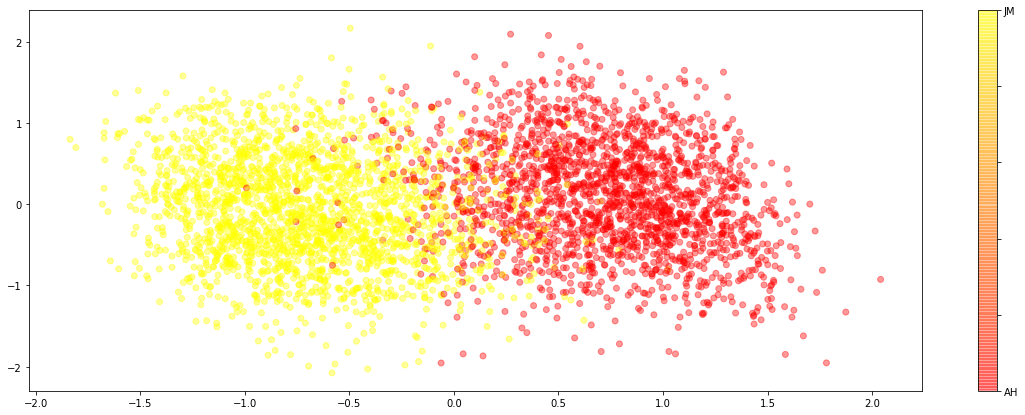

In [ ]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker

pca = PCA(n_components=2, random_state=12345)
transformed_values = pca.fit_transform(lstm_vectors)

plt.figure(figsize=(20,7))
plt.scatter(transformed_values[:,0], transformed_values[:,1], c=real_labels.ravel(), cmap='autumn', alpha=0.4)
colorbar = plt.colorbar();

def colorbar_labeler(value, _):
    if value == float(AH):
        return "AH"
    elif value == float(JM):
        return "JM"
    return ""

colorbar.formatter = ticker.FuncFormatter(colorbar_labeler)
colorbar.update_ticks()


Explained variance: 39.48440498113632%


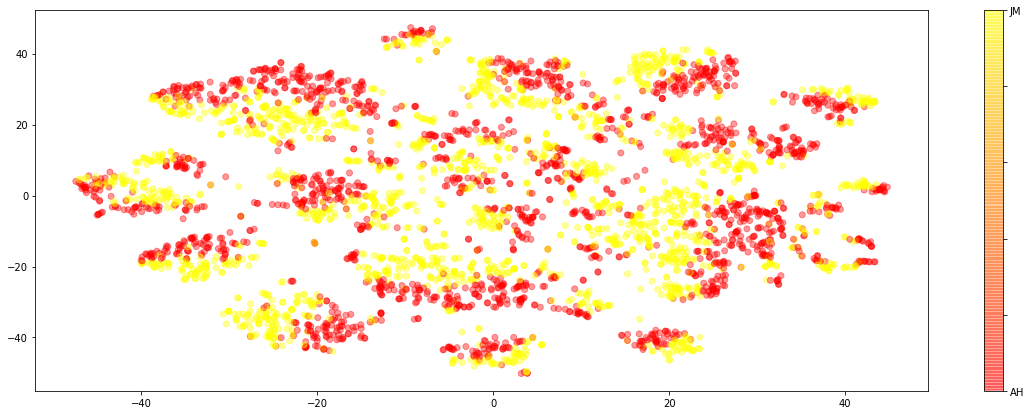

In [ ]:
from sklearn.manifold import TSNE

NUM_DIMENSIONS = 30   
NUM_ITERATIONS = 500   # No less than 250

pca = PCA(n_components=NUM_DIMENSIONS, random_state=12345)
pca_values = pca.fit_transform(lstm_vectors)
print("Explained variance: {}%".format(sum(pca.explained_variance_ratio_ * 100)))

tsne = TSNE(n_iter=NUM_ITERATIONS)
transformed_values = tsne.fit_transform(pca_values)

plt.figure(figsize=(20,7))
plt.scatter(transformed_values[:,0], transformed_values[:,1], c=real_labels.ravel(), cmap='autumn', alpha=0.4)
colorbar = plt.colorbar();

colorbar.formatter = ticker.FuncFormatter(colorbar_labeler)
colorbar.update_ticks()

In [ ]:
for x in sorted(os.listdir('./unknown/')):

    disputed_text = preprocess_text('./unknown/' + x)
    disputed_long_sequence = tokenizer.texts_to_sequences([disputed_text])[0]
    X_sequences, _ = make_subsequences(disputed_long_sequence, UNKNOWN)
    X_sequences = X_sequences.reshape((-1,SEQ_LEN,1))
    
    with g.as_default():
        
        votes_for_madison = 0
        votes_for_hamilton = 0
        
        dataset = make_dataset(X_sequences, np.zeros((X_sequences.shape[0], 1)))
        sess.run(data_iterator.make_initializer(dataset))
        
        try:
            while True:        
                predictions  = sess.run(tf.round(logits), feed_dict={"Options/mode:0":"test"})
                counts = np.unique(predictions, return_counts=True)[1]
                votes_for_hamilton += counts[AH]
                votes_for_madison += counts[JM]
            
        except tf.errors.OutOfRangeError:
            pass

        
        print("Paper {} is predicted to have been written by {}, {} to {}".format(
                x.replace('paper_','').replace('.txt',''), 
                ("Alexander Hamilton" if votes_for_hamilton > votes_for_madison else "James Madison"),
                max(votes_for_hamilton, votes_for_madison), min(votes_for_hamilton, votes_for_madison)))
        
        

Paper 49 is predicted to have been written by James Madison, 5925 to 4157
Paper 50 is predicted to have been written by James Madison, 4511 to 2394
Paper 51 is predicted to have been written by James Madison, 6898 to 4830
Paper 52 is predicted to have been written by James Madison, 6920 to 4182
Paper 53 is predicted to have been written by James Madison, 7154 to 5958
Paper 54 is predicted to have been written by James Madison, 7117 to 4765
Paper 55 is predicted to have been written by James Madison, 6912 to 5214
Paper 56 is predicted to have been written by James Madison, 5036 to 4581
Paper 57 is predicted to have been written by James Madison, 7629 to 5522
Paper 58 is predicted to have been written by James Madison, 7417 to 5308
Paper 62 is predicted to have been written by James Madison, 8292 to 5893
Paper 63 is predicted to have been written by James Madison, 10561 to 7742
